# # GROW Dataset: Exploratory Data Analysis and SGI-based Drought Assessment

# ## Notebook Goals:
# 1. Load and perform an initial Exploratory Data Analysis (EDA) on the GROW attributes and time series datasets.
# 2. Understand data characteristics, missing values, and distributions relevant for drought analysis.
# 3. Outline the methodology for calculating the Standardized Groundwater Index (SGI), inspired by the Popat & Hartmann (2024) study on SSI.
# 4. Identify a suitable region (e.g., France) for a focused SGI analysis based on data availability and quality.
# 5. Preprocess time series data for the selected region to prepare for SGI calculation.
# 6. Calculate SGI for the selected sites.
# 7. Classify drought conditions based on SGI values.
# 8. Save processed data and SGI results.
# 9. Suggest next steps for drought classification research.

In [2]:
# Cell Type: code
# --- 1. Setup and Imports ---

# It's good practice to manage installations outside the notebook,
# but for completeness, if you were to run this in a new environment:
# !pip install pandas pyarrow matplotlib seaborn scipy pastas geopandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy import stats
import pastas as ps # Will be used for more advanced modeling later
import os

# For interactive maps (optional, requires geopandas)
try:
    import geopandas as gpd
    from mpl_toolkits.axes_grid1 import make_axes_locatable # For colorbar
    import ipywidgets as widgets
    from ipywidgets import interactive, VBox, HBox, HTML
    from IPython.display import display, clear_output
    GEOPANDAS_AVAILABLE = True
except ImportError:
    GEOPANDAS_AVAILABLE = False
    print("Geopandas or ipywidgets not found. Spatial interactive maps will be skipped.")

# Set display options for pandas
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)
pd.set_option("display.max_colwidth", 100)

# Set plot style
plt.style.use("seaborn-v0_8-whitegrid")

print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Pastas version: {ps.__version__}")
if GEOPANDAS_AVAILABLE:
    print(f"GeoPandas version: {gpd.__version__}")

# --- Configuration ---
DATA_PATH = "./Daten/" # Adjust if your data is elsewhere
OUTPUT_PATH = "./Daten/Processed/" # For saving new files

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Primary groundwater measurement column for SGI
GW_VALUE_COL = "groundwater_depth_from_ground_m"

Geopandas or ipywidgets not found. Spatial interactive maps will be skipped.
Pandas version: 2.2.3
Numpy version: 1.26.4
Matplotlib version: 3.10.0
Seaborn version: 0.13.2
Pastas version: 1.9.0


In [3]:
# Cell Type: code
# --- 2. Load Data ---
print("Loading datasets...")
try:
    attributes_df_raw = pd.read_parquet(os.path.join(DATA_PATH, "grow_attributes.parquet"))
    timeseries_df_raw = pd.read_parquet(os.path.join(DATA_PATH, "grow_timeseries.parquet"))
    print("Datasets loaded successfully.")
except Exception as e:
    print(f"Error loading datasets: {e}")
    print(
        "Please ensure 'grow_attributes.parquet' and 'grow_timeseries.parquet' "
        "are in the specified DATA_PATH."
    )
    attributes_df_raw = pd.DataFrame()
    timeseries_df_raw = pd.DataFrame()

# Create copies for manipulation to keep raw data intact
attributes_df = attributes_df_raw.copy()
timeseries_df = timeseries_df_raw.copy()

Loading datasets...
Datasets loaded successfully.


In [4]:
# Cell Type: code
# --- 3.1 Attributes Table: Basic Overview ---
if not attributes_df.empty:
    print("--- Attributes DataFrame ---")
    print(f"\nShape: {attributes_df.shape}")

    print("\nInfo:")
    attributes_df.info()

    print("\nHead:")
    display(attributes_df.head())

    print("\nBasic Statistics (Numerical):")
    display(attributes_df.describe(include=np.number))

    print("\nBasic Statistics (Categorical/Object/Bool):")
    display(attributes_df.describe(include=['object', 'bool']))
else:
    print("Attributes DataFrame is empty or failed to load.")

--- Attributes DataFrame ---

Shape: (187317, 50)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187317 entries, 0 to 187316
Data columns (total 50 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   GROW_ID                                       187317 non-null  object 
 1   original_ID_groundwater                       187317 non-null  object 
 2   name                                          187317 non-null  object 
 3   feature_type                                  187317 non-null  object 
 4   purpose                                       173571 non-null  object 
 5   status                                        161480 non-null  object 
 6   description                                   33670 non-null   object 
 7   latitude                                      187317 non-null  float64
 8   longitude                                     187317 non-null  floa

,GROW_ID,original_ID_groundwater,name,feature_type,purpose,status,description,latitude,longitude,surface_elevation_m_asl,top_of_well_elevation_m_asl,country,address,license,aquifer_name,confinement,organisation,manager,drilling_total_depth_m,interval,starting_date,ending_date,length_years,autocorrelation,aggregated_from_n_values_median,gap_fraction,jumps,plateaus,trend_direction,trend_slope_m_year-1,reference_point,groundwater_mean_m,groundwater_median_m,koeppen_geiger_class,hydrobelt_class,ground_elevation_m_asl,topographic_slope_degrees,rock_type_class,aquifer_type_class,rock_permeability_m2,rock_porosity_fraction,soil_texture_0-30_cm_class,soil_texture_30-200_cm_class,soil_saturated_conductivity_0-30_cm_cm_d-1,soil_saturated_conductivity_30-200_cm_cm_d-1,distance_perennial_streams_m,drainage_density_m-1,groundwater_dependent_ecosystems_class,groundwaterscapes_ID_class,main_landuse
0,GROW-67596016696,420010191,420010191,Water well,Observation / monitoring,Active,None,39.9092,116.3950,NaN,NaN,CHN,None,None,None,None,Jasechko et al. (2024) Rapid groundwater decline and some cases of recovery in aquifers globally,None,NaN,YS,2005-01-01,2013-01-01,9,False,NaN,0.0,False,False,no trend,NaN,Water depth [from the ground surface],24.725000,24.210,Dwa,Mid Latitude,49.0,0.32,unconsolidated sediments,porous,3.019952e-11,0.0,Medium,None,27.4806,10.1252,14800.0,0.000260,Lentic,10.0,cropland_irrigated
1,GROW-67596220867,420010192,420010192,Water well,Observation / monitoring,Active,None,39.8825,116.4092,NaN,NaN,CHN,None,None,None,None,Jasechko et al. (2024) Rapid groundwater decline and some cases of recovery in aquifers globally,None,NaN,YS,2005-01-01,2013-01-01,9,False,NaN,0.0,False,False,no trend,NaN,Water depth [from the ground surface],25.594444,25.395,Dwa,Mid Latitude,47.8,0.36,unconsolidated sediments,porous,3.019952e-11,0.0,Medium,None,28.4808,10.1275,11200.0,0.000260,Lentic,10.0,cropland_irrigated
2,GROW-67596357568,420010193,420010193,Water well,Observation / monitoring,Active,None,39.9086,116.6158,NaN,NaN,CHN,None,None,None,None,Jasechko et al. (2024) Rapid groundwater decline and some cases of recovery in aquifers globally,None,NaN,YS,2005-01-01,2013-01-01,9,False,NaN,0.0,False,False,decreasing,0.38000,Water depth [from the ground surface],15.712778,15.510,Dwa,Mid Latitude,29.2,0.50,unconsolidated sediments,porous,3.019952e-11,0.0,Medium,None,21.2501,7.8173,6400.0,0.000246,No GDE,10.0,cropland_irrigated
3,GROW-67596479749,420010194,420010194,Water well,Observation / monitoring,Active,None,39.9086,116.6158,NaN,NaN,CHN,None,None,None,None,Jasechko et al. (2024) Rapid groundwater decline and some cases of recovery in aquifers globally,None,NaN,YS,2005-01-01,2013-01-01,9,False,NaN,0.0,False,False,decreasing,2.17450,Water depth [from the ground surface],60.923889,61.395,Dwa,Mid Latitude,29.2,0.50,unconsolidated sediments,porous,3.019952e-11,0.0,Medium,None,21.2501,7.8173,6400.0,0.000246,No GDE,10.0,cropland_irrigated
4,GROW-67596594680,420010195,420010195,Water well,Observation / monitoring,Active,None,40.0181,116.5147,NaN,NaN,CHN,None,None,None,None,Jasechko et al. (2024) Rapid groundwater decline and some cases of recovery in aquifers globally,None,NaN,YS,2005-01-01,2013-01-01,9,False,NaN,0.0,False,False,decreasing,0.86625,Water depth [from the ground surface],49.062778,49.650,Dwa,Mid Latitude,38.9,0.12,unconsolidated sediments,porous,3.019952e-11,0.0,Medium,Medium,49.0315,15.9266,8700.0,0.000243,No GDE,10.0,cropland_irrigated



Basic Statistics (Numerical):


,latitude,longitude,surface_elevation_m_asl,top_of_well_elevation_m_asl,drilling_total_depth_m,length_years,aggregated_from_n_values_median,gap_fraction,trend_slope_m_year-1,groundwater_mean_m,groundwater_median_m,ground_elevation_m_asl,topographic_slope_degrees,rock_permeability_m2,rock_porosity_fraction,soil_saturated_conductivity_0-30_cm_cm_d-1,soil_saturated_conductivity_30-200_cm_cm_d-1,distance_perennial_streams_m,drainage_density_m-1,groundwaterscapes_ID_class
count,187317.000000,187317.000000,36506.000000,4210.000000,11574.000000,187317.000000,70787.000000,187317.000000,71438.000000,187317.000000,187317.000000,187317.000000,187195.000000,1.869520e+05,186954.000000,187027.000000,187027.000000,1.868540e+05,1.863680e+05,173460.000000
mean,23.725834,-38.409684,350.963614,784.628019,97.131122,14.404357,2.679404,0.006809,0.122399,25.134190,25.033845,292.265945,1.078137,1.542639e-11,0.046186,39.900656,15.658943,2.687111e+04,2.524578e-04,9.939150
std,28.018664,101.430471,424.502306,867.591135,104.210421,12.646508,2.417380,0.026957,10.121966,74.099158,74.389544,436.687134,1.749948,1.488854e-11,0.084379,54.286585,21.623609,7.830171e+04,5.527026e-05,2.715528
min,-44.916500,-159.744000,-32.004000,0.616000,0.000000,1.000000,1.000000,0.000000,-2646.250000,-161.638063,-161.877778,-57.500000,0.000000,3.162278e-17,0.000000,1.150500,0.392500,2.000000e+02,6.160560e-10,1.000000
25%,26.446944,-118.145500,39.000000,26.000000,33.573720,6.000000,1.000000,0.000000,-0.040347,3.449204,3.400044,25.100000,0.220000,1.000000e-14,0.000000,19.164700,7.502400,4.200000e+03,2.262487e-04,10.000000
50%,34.281300,-97.917550,163.000000,250.475000,68.580000,11.000000,2.000000,0.000000,0.074675,7.940650,7.870000,102.100000,0.520000,3.019952e-11,0.000000,31.378100,12.179800,6.400000e+03,2.513141e-04,10.000000
75%,39.026100,7.748451,544.222450,1745.735000,121.005600,18.000000,4.000000,0.000000,0.229765,21.181907,21.010000,321.400000,1.210000,3.019952e-11,0.060000,45.126000,16.941500,1.360000e+04,2.794352e-04,11.000000
max,78.922000,173.720100,3856.000000,2731.350000,1310.640000,135.000000,96.000000,0.200000,319.070833,6666.809503,6743.300000,3846.700000,43.430000,3.019952e-11,0.280000,1440.240000,570.070000,1.215500e+06,2.333903e-03,15.000000



Basic Statistics (Categorical/Object/Bool):


,GROW_ID,original_ID_groundwater,name,feature_type,purpose,status,description,country,address,license,aquifer_name,confinement,organisation,manager,interval,starting_date,ending_date,autocorrelation,jumps,plateaus,trend_direction,reference_point,koeppen_geiger_class,hydrobelt_class,rock_type_class,aquifer_type_class,soil_texture_0-30_cm_class,soil_texture_30-200_cm_class,groundwater_dependent_ecosystems_class,main_landuse
count,187317,187317,187317,187317,173571,161480,33670,187317,12487,58675,11427,12094,187317,12403,187317,187317,187317,187317,187317,187317,187317,187317,187317,168951,180584,181605,187027,120264,187317,186704
unique,187317,187156,177740,1,2,3,11234,41,1037,3,968,2,48,51,3,6005,4884,2,2,2,3,3,23,5,14,4,6,6,8,5
top,GROW-67596016696,371,Bordeaux,Water well,Observation / monitoring,Active,This well was obtained at the Australian Groundwater Explorer (http://www.bom.gov.au/water/groun...,USA,Veracruz de Ignacio de la Llave,Attribution 4.0 International (CC BY 4.0),Ogallala Formation (121OGLL),Unconfined,Provisional,U.S. Geological Survey,YS,2002-01-01,2022-01-01,False,False,False,no trend,Water depth [from the ground surface],BSk,Mid Latitude,unconsolidated sediments,porous,Medium,Medium,Lentic,forests_and_natural_vegetation
freq,1,3,296,187317,173556,161046,11903,110316,634,26220,1472,7858,96841,3408,154627,19976,26396,146133,186602,179960,115879,181961,40705,142917,88951,124613,155314,79398,101857,59362


In [5]:
# Cell Type: code
# --- 3.2 Attributes Table: Missing Values ---
if not attributes_df.empty:
    print("\nMissing values per column (%):")
    missing_summary = attributes_df.isnull().sum()
    missing_percentage = (missing_summary / len(attributes_df)) * 100
    missing_df = pd.DataFrame({'Missing Count': missing_summary, 'Missing Percentage': missing_percentage})
    display(missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False).head(20))
else:
    print("Attributes DataFrame is empty.")


Missing values per column (%):


,Missing Count,Missing Percentage
top_of_well_elevation_m_asl,183107,97.752473
aquifer_name,175890,93.899646
drilling_total_depth_m,175743,93.821169
confinement,175223,93.543565
manager,174914,93.378604
address,174830,93.333760
description,153647,82.025123
surface_elevation_m_asl,150811,80.511112
license,128642,68.676095
aggregated_from_n_values_median,116530,62.210050


In [6]:
# Cell Type: code
# --- 3.3 Attributes Table: Value Counts for Key Categorical Columns ---
if not attributes_df.empty:
    key_categorical_cols_attrs = [
        "country", "interval", "trend_direction", "feature_type", "purpose",
        "status", "reference_point", "koeppen_geiger_class", "hydrobelt_class",
        "rock_type_class", "aquifer_type_class", "main_landuse",
        "groundwater_dependent_ecosystems_class"
    ]
    for col in key_categorical_cols_attrs:
        if col in attributes_df.columns:
            print(f"\nValue counts for '{col}':")
            display(attributes_df[col].value_counts(dropna=False).head(10))
        else:
            print(f"Column '{col}' not found in attributes_df.")
else:
    print("Attributes DataFrame is empty.")


Value counts for 'country':


country
USA    110316
AUS     33275
FRA     16154
IND      8187
MEX      4245
ESP      3571
CAN      2546
BEL      1418
CHL      1083
TWN       945
Name: count, dtype: int64


Value counts for 'interval':


interval
YS    154627
MS     21443
d      11247
Name: count, dtype: int64


Value counts for 'trend_direction':


trend_direction
no trend      115879
decreasing     48749
increasing     22689
Name: count, dtype: int64


Value counts for 'feature_type':


feature_type
Water well    187317
Name: count, dtype: int64


Value counts for 'purpose':


purpose
Observation / monitoring    173556
None                         13746
Production                      15
Name: count, dtype: int64


Value counts for 'status':


status
Active       161046
None          25837
Abandoned       432
Collapsed         2
Name: count, dtype: int64


Value counts for 'reference_point':


reference_point
Water depth [from the ground surface]     181961
Water level elevation a.m.s.l.              5349
Water depth [from the top of the well]         7
Name: count, dtype: int64


Value counts for 'koeppen_geiger_class':


koeppen_geiger_class
BSk     40705
Cfa     34319
Csa     26199
LCsb    25844
Cfb     23250
BSh      6769
Dfa      5888
Cwa      5570
Aw       5317
BWh      4608
Name: count, dtype: int64


Value counts for 'hydrobelt_class':


hydrobelt_class
Mid Latitude    142917
None             18366
Dry              15841
Sub Tropical      7845
Boreal            2192
Equatorial         156
Name: count, dtype: int64


Value counts for 'rock_type_class':


rock_type_class
unconsolidated sediments           88951
siliciclastic sedimentary rocks    36449
carbonate sedimentary rocks        13182
acid plutonic rocks                10621
mixed sedimentary rocks             9944
None                                6733
metamorphic rocks                   6042
water bodies                        5698
basic volcanic rocks                4153
acid volcanic rocks                 3868
Name: count, dtype: int64


Value counts for 'aquifer_type_class':


aquifer_type_class
porous        124613
karst          25963
fractured      25507
None            5712
water_body      5522
Name: count, dtype: int64


Value counts for 'main_landuse':


main_landuse
forests_and_natural_vegetation    59362
pastures                          45558
cropland_rainfed                  31385
urbanareas                        27050
cropland_irrigated                23349
None                                613
Name: count, dtype: int64


Value counts for 'groundwater_dependent_ecosystems_class':


groundwater_dependent_ecosystems_class
Lentic                                  101857
No GDE                                   48847
Terrestrial and lentic                   15308
Lentic and lotic                         10927
Terrestrial, lentic, and lotic (all)      7586
Terrestrial                               2709
Lotic                                       76
Terrestrial and lotic                        7
Name: count, dtype: int64

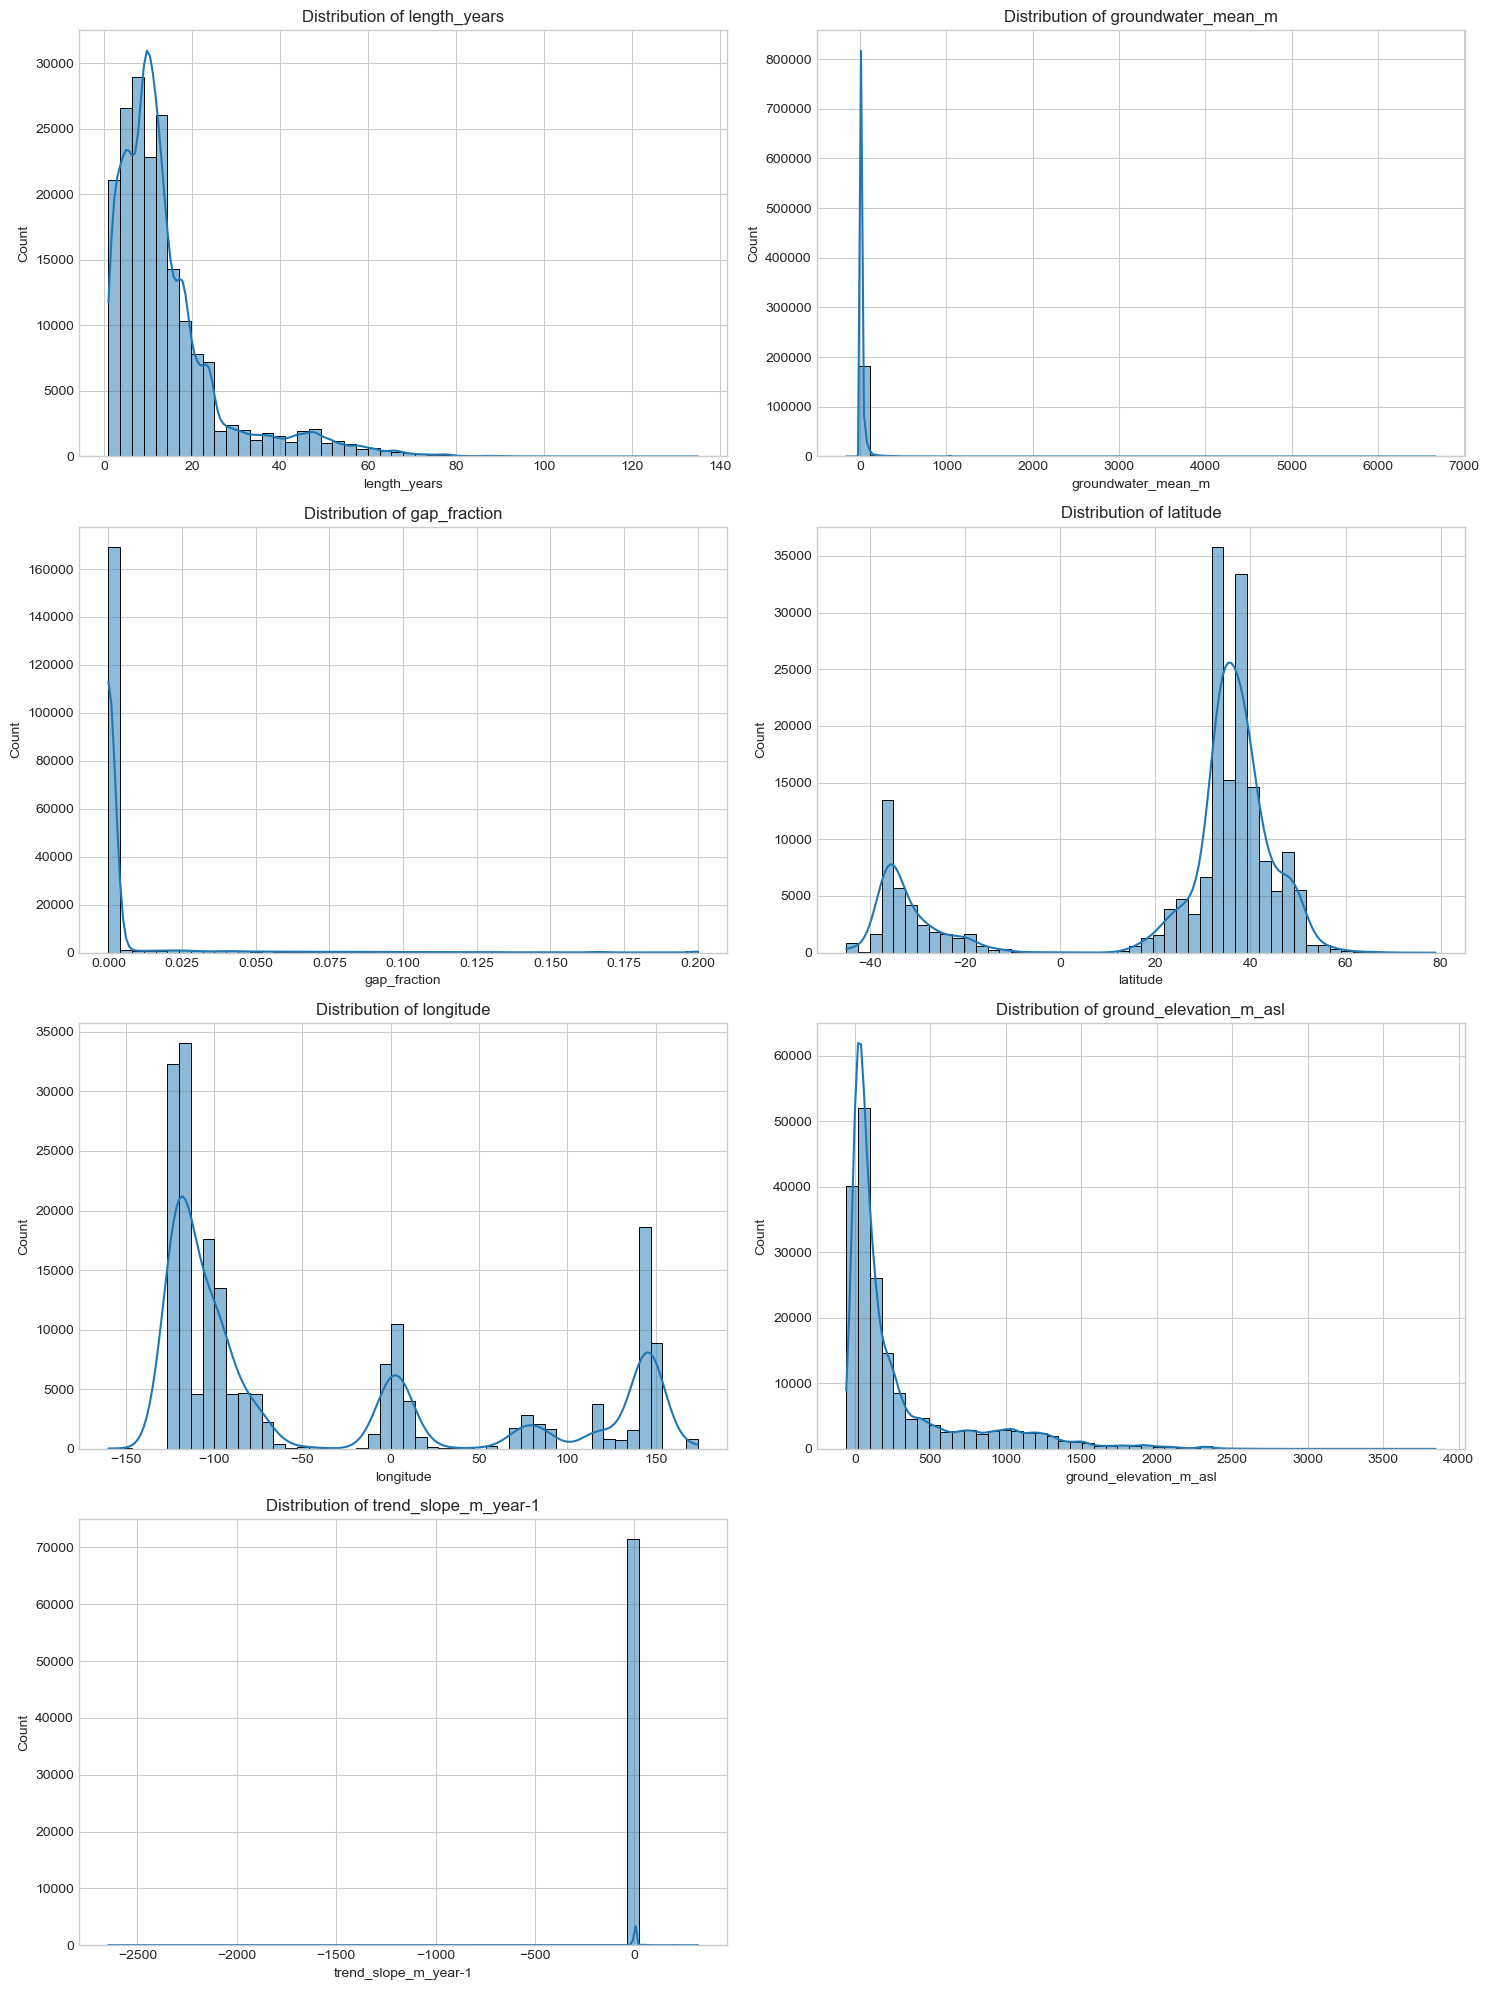

In [7]:
# Cell Type: code
# --- 3.4 Attributes Table: Distributions of Key Numerical Columns ---
if not attributes_df.empty:
    key_numerical_cols_attrs = [
        "length_years", "groundwater_mean_m", "gap_fraction",
        "latitude", "longitude", "ground_elevation_m_asl",
        "trend_slope_m_year-1"
    ]
    
    fig, axes = plt.subplots(nrows=(len(key_numerical_cols_attrs) + 1) // 2, ncols=2, figsize=(15, 5 * ((len(key_numerical_cols_attrs) + 1) // 2)))
    axes = axes.flatten() # Flatten to 1D array for easy iteration

    for i, col in enumerate(key_numerical_cols_attrs):
        if col in attributes_df.columns:
            sns.histplot(attributes_df[col].dropna(), kde=True, ax=axes[i], bins=50)
            axes[i].set_title(f"Distribution of {col}")
        else:
            print(f"Column '{col}' not found for plotting.")
            axes[i].set_visible(False) # Hide axis if column not found
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
        
    plt.tight_layout()
    plt.show()
else:
    print("Attributes DataFrame is empty.")

In [8]:
# Cell Type: code
# --- 3.5 Attributes Table: Unique GROW_IDs ---
if not attributes_df.empty and "GROW_ID" in attributes_df.columns:
    print(f"\nNumber of unique sites in attributes_df (based on GROW_ID): {attributes_df['GROW_ID'].nunique()}")
else:
    print("\n'GROW_ID' column not found or attributes_df is empty.")


Number of unique sites in attributes_df (based on GROW_ID): 187317


In [9]:
# Cell Type: code
# --- 4.1 Time Series Table: Basic Overview & Date Conversion ---
if not timeseries_df.empty:
    print("--- Time Series DataFrame ---")
    print(f"\nShape: {timeseries_df.shape}")

    print("\nInfo (initial):")
    timeseries_df.info(verbose=False, memory_usage='deep') # Show memory usage

    # Convert 'date' column to datetime if it's not already
    if "date" in timeseries_df.columns:
        if not pd.api.types.is_datetime64_any_dtype(timeseries_df["date"]):
            print("\nConverting 'date' column to datetime...")
            try:
                timeseries_df["date"] = pd.to_datetime(timeseries_df["date"])
                print("'date' column converted to datetime.")
            except Exception as e:
                print(f"Error converting 'date' to datetime: {e}")
        else:
            print("\n'date' column is already datetime.")
    else:
        print("\n'date' column not found in timeseries_df.")

    print("\nHead:")
    display(timeseries_df.head())

    print("\nBasic Statistics (Numerical):")
    display(timeseries_df.describe(include=np.number))
    
    # Check data types of key columns
    print("\nData types for key timeseries columns:")
    key_ts_cols_types = ["GROW_ID", "date", GW_VALUE_COL]
    for col in key_ts_cols_types:
        if col in timeseries_df.columns:
            print(f"{col}: {timeseries_df[col].dtype}")
        else:
            print(f"{col}: Not found")
else:
    print("Time Series DataFrame is empty or failed to load.")

--- Time Series DataFrame ---

Shape: (33900200, 26)

Info (initial):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33900200 entries, 0 to 33900199
Columns: 26 entries, GROW_ID to forests_natural_vegetation_fraction
dtypes: float64(19), int64(2), object(5)
memory usage: 15.5 GB

Converting 'date' column to datetime...
'date' column converted to datetime.

Head:


,GROW_ID,country,interval,date,year,month,aggregated_from_n_values,plateaus,groundwater_depth_from_ground_m,groundwater_depth_from_well_top_m,groundwater_level_m_asl,groundwater_filled_depth_from_ground_m,groundwater_filled_depth_from_top_elevation_m,groundwater_filled_level_m_asl,precipitation_gpcc_mm_year-1,potential_evapotranspiration_gleam_mm_year-1,actual_evapotranspiration_mm_year-1,interception_mm_year-1,ndvi_ratio,withdrawal_industrial_m3_year-1,withdrawal_domestic_m3_year-1,urban_area_fraction,pastures_fraction,cropland_rainfed_fraction,cropland_irrigated_fraction,forests_natural_vegetation_fraction
0,GROW-72146819787,USA,YS,1957-01-01,1957,1957-01,NaN,0,1.661160,NaN,NaN,1.661160,NaN,NaN,1994.24,NaN,NaN,NaN,NaN,3.625384e+07,4.873274e+06,0.003493,0.216441,0.077578,0.544593,0.156448
1,GROW-72146819787,USA,YS,1958-01-01,1958,1958-01,NaN,0,1.530096,NaN,NaN,1.530096,NaN,NaN,1198.30,NaN,NaN,NaN,NaN,3.732096e+07,4.939641e+06,0.003503,0.216745,0.067127,0.551076,0.160104
2,GROW-72146819787,USA,YS,1959-01-01,1959,1959-01,NaN,0,1.402080,NaN,NaN,1.402080,NaN,NaN,1001.58,NaN,NaN,NaN,NaN,3.877158e+07,5.062311e+06,0.003514,0.217049,0.056675,0.557558,0.163759
3,GROW-72146819787,USA,YS,1960-01-01,1960,1960-01,NaN,0,2.197608,NaN,NaN,2.197608,NaN,NaN,900.38,NaN,NaN,NaN,NaN,4.084223e+07,4.965556e+06,0.003524,0.217352,0.046223,0.564040,0.167414
4,GROW-72146819787,USA,YS,1961-01-01,1961,1961-01,NaN,0,2.112264,NaN,NaN,2.112264,NaN,NaN,1294.08,NaN,NaN,NaN,NaN,4.269508e+07,5.103916e+06,0.003579,0.213992,0.042957,0.579345,0.158681



Basic Statistics (Numerical):


,year,aggregated_from_n_values,plateaus,groundwater_depth_from_ground_m,groundwater_depth_from_well_top_m,groundwater_level_m_asl,groundwater_filled_depth_from_ground_m,groundwater_filled_depth_from_top_elevation_m,groundwater_filled_level_m_asl,precipitation_gpcc_mm_year-1,potential_evapotranspiration_gleam_mm_year-1,actual_evapotranspiration_mm_year-1,interception_mm_year-1,ndvi_ratio,withdrawal_industrial_m3_year-1,withdrawal_domestic_m3_year-1,urban_area_fraction,pastures_fraction,cropland_rainfed_fraction,cropland_irrigated_fraction,forests_natural_vegetation_fraction
count,3.390020e+07,1.617686e+07,3.390020e+07,3.039573e+07,1456.000000,3.265916e+06,3.061598e+07,1485.000000,3.282735e+06,2.890865e+07,3.064763e+07,3.064763e+07,3.064763e+07,3.136102e+07,3.070993e+07,3.070993e+07,3.070982e+07,3.070982e+07,3.070982e+07,3.070982e+07,3.070982e+07
mean,2.011566e+03,2.049331e+00,8.219928e-01,2.198243e+01,18.478115,4.075809e+02,2.198281e+01,18.444128,4.077829e+02,8.640290e+02,1.194640e+03,6.040798e+02,6.248908e+01,2.587242e-01,1.605586e+08,4.804611e+07,3.839610e-02,1.945882e-01,2.546343e-01,3.681215e-02,3.933891e-01
std,1.083709e+01,3.017865e+00,1.250170e+01,8.914750e+01,14.247477,3.165705e+02,8.889913e+01,14.253497,3.161377e+02,7.207666e+02,7.940774e+02,4.881865e+02,9.839011e+01,2.258959e-01,4.161000e+08,1.218870e+08,8.514671e-02,1.730673e-01,1.985509e-01,9.814371e-02,2.389146e-01
min,1.838000e+03,1.000000e+00,0.000000e+00,0.000000e+00,-0.210000,-1.634400e+02,0.000000e+00,-0.210000,-1.634400e+02,0.000000e+00,-8.161034e+01,-8.161034e+01,0.000000e+00,-9.644000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.009000e+03,1.000000e+00,0.000000e+00,3.340000e+00,7.107632,1.726860e+02,3.340000e+00,7.101579,1.739550e+02,3.817200e+02,5.462888e+02,2.125261e+02,0.000000e+00,5.300000e-02,7.706521e+06,4.925887e+06,2.333366e-03,7.946412e-02,8.116244e-02,0.000000e+00,1.969287e-01
50%,2.014000e+03,1.000000e+00,0.000000e+00,8.280000e+00,11.097045,3.748000e+02,8.296656e+00,11.086364,3.749200e+02,7.117200e+02,1.120698e+03,4.933569e+02,2.290948e+01,2.199100e-01,3.313133e+07,1.389791e+07,8.911694e-03,1.648913e-01,2.280416e-01,0.000000e+00,3.591953e-01
75%,2.019000e+03,1.000000e+00,0.000000e+00,2.189302e+01,28.163977,6.104600e+02,2.192731e+01,28.116364,6.103200e+02,1.157760e+03,1.690481e+03,9.097261e+02,8.257950e+01,4.209000e-01,1.196717e+08,3.575931e+07,2.629048e-02,2.476954e-01,3.895058e-01,1.559261e-02,5.587344e-01
max,2.024000e+03,2.730000e+02,1.152000e+03,4.975225e+04,45.829091,2.068465e+03,4.975225e+04,45.829091,2.068465e+03,2.726160e+04,1.088459e+04,1.088459e+04,1.083326e+04,1.000000e+00,5.304749e+09,2.163686e+09,7.687857e-01,1.000000e+00,9.926569e-01,8.986009e-01,1.000000e+00



Data types for key timeseries columns:
GROW_ID: object
date: datetime64[ns]
groundwater_depth_from_ground_m: float64



Missing values in 'groundwater_depth_from_ground_m': 3504468
Percentage missing: 10.34%


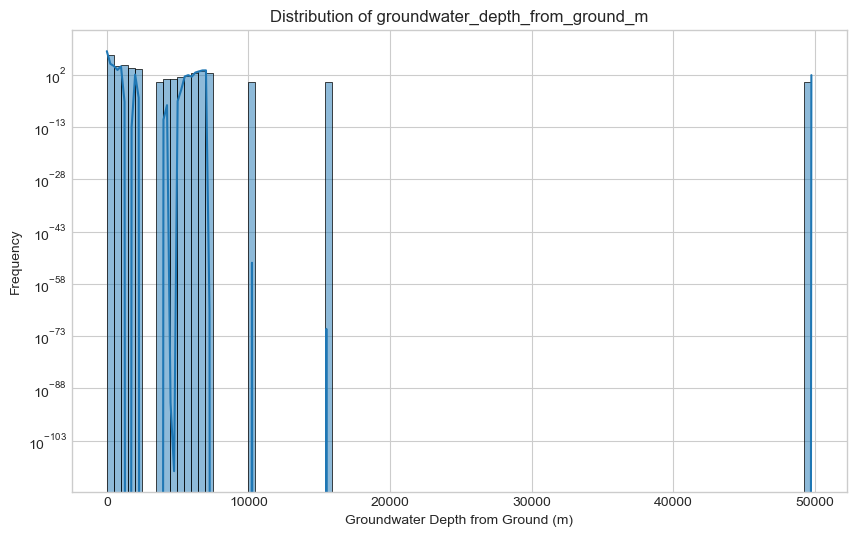

In [11]:
# Cell Type: code
# --- 4.2 Time Series Table: Missing Values in Measurement Column ---
if not timeseries_df.empty and GW_VALUE_COL in timeseries_df.columns:
    missing_gw_values = timeseries_df[GW_VALUE_COL].isnull().sum()
    print(f"\nMissing values in '{GW_VALUE_COL}': {missing_gw_values}")
    if len(timeseries_df) > 0:
        print(f"Percentage missing: {missing_gw_values * 100 / len(timeseries_df):.2f}%")
    
    # Distribution of the GW_VALUE_COL
    plt.figure(figsize=(10, 6))
    sns.histplot(timeseries_df[GW_VALUE_COL].dropna(), kde=True, bins=100) # Increased bins
    plt.title(f"Distribution of {GW_VALUE_COL}")
    plt.xlabel("Groundwater Depth from Ground (m)")
    plt.ylabel("Frequency")
    # Consider log scale if highly skewed for visualization, but be careful for SGI
    plt.yscale('log')
    plt.show()
else:
    print(f"'{GW_VALUE_COL}' not found or timeseries_df is empty.")

In [12]:
# Cell Type: code
# --- 4.3 Time Series Table: Time Range and Unique GROW_IDs ---
if not timeseries_df.empty:
    if "date" in timeseries_df.columns and pd.api.types.is_datetime64_any_dtype(timeseries_df["date"]):
        print(f"\nOverall time range of measurements:")
        print(f"Min date: {timeseries_df['date'].min()}")
        print(f"Max date: {timeseries_df['date'].max()}")
    
    if "GROW_ID" in timeseries_df.columns:
        num_unique_sites_ts = timeseries_df['GROW_ID'].nunique()
        print(f"\nNumber of unique sites in timeseries_df (based on GROW_ID): {num_unique_sites_ts}")
        if not attributes_df.empty and "GROW_ID" in attributes_df.columns:
            if num_unique_sites_ts == attributes_df['GROW_ID'].nunique():
                print("Number of unique GROW_IDs matches between attributes and time series tables.")
            else:
                print("Warning: Number of unique GROW_IDs MISMATCHES between tables!")
                print(f"  Attributes GROW_IDs: {attributes_df['GROW_ID'].nunique()}")
                print(f"  Time Series GROW_IDs: {num_unique_sites_ts}")
    else:
        print("\n'GROW_ID' column not found in timeseries_df.")
else:
    print("Time Series DataFrame is empty.")


Overall time range of measurements:
Min date: 1838-10-01 00:00:00
Max date: 2024-04-23 00:00:00

Number of unique sites in timeseries_df (based on GROW_ID): 187317
Number of unique GROW_IDs matches between attributes and time series tables.



--- Plotting Example Time Series ---

Selected example_ids for plotting: ['GROW-83682358539', 'GROW-80135405421', 'GROW-83147165001']


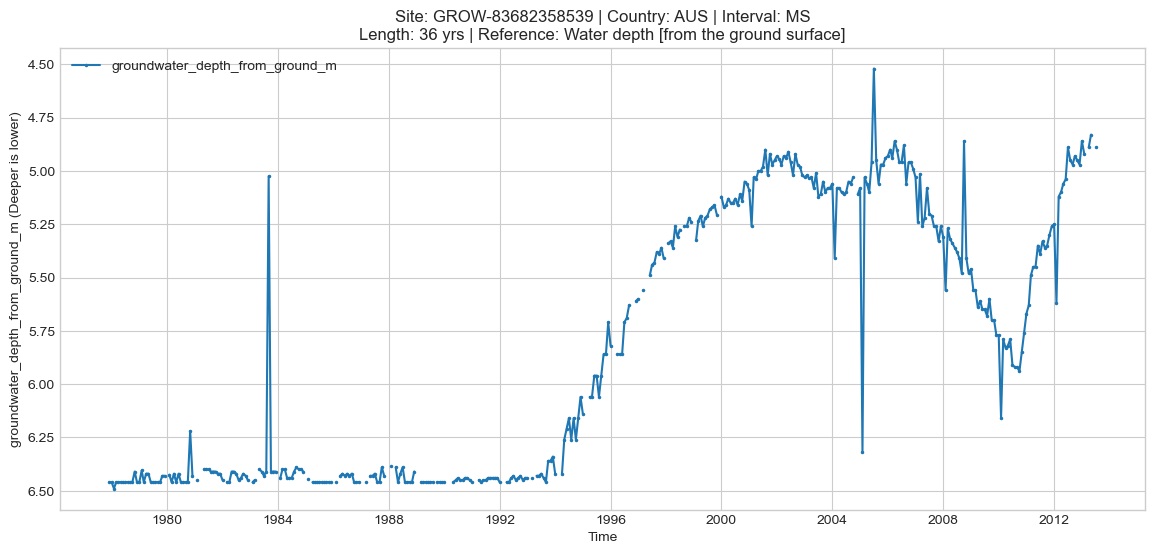

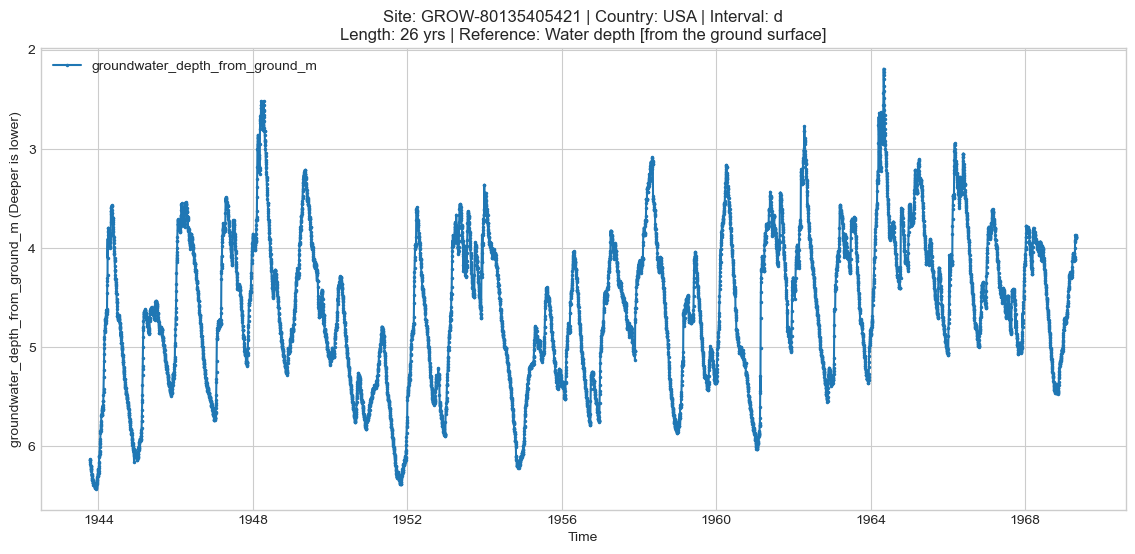

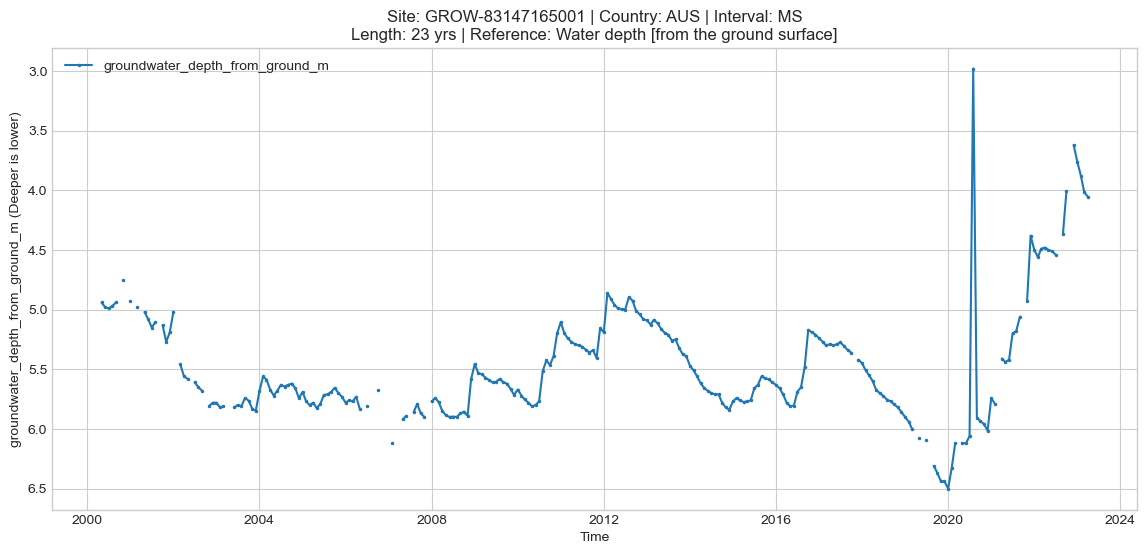

In [13]:
# Cell Type: code
# --- 5.1 Select and Plot Example Time Series ---
if not attributes_df.empty and not timeseries_df.empty and "GROW_ID" in attributes_df.columns and "GROW_ID" in timeseries_df.columns:
    print("\n--- Plotting Example Time Series ---")

    example_ids_to_plot = []
    # Try to get sites with good data for SGI demo (long, monthly/daily)
    candidate_sites = attributes_df[
        (attributes_df["length_years"] >= 20) &
        (attributes_df["interval"].isin(["MS", "d"])) &
        (attributes_df["gap_fraction"] <= 0.20) # Low gap fraction
    ]
    if not candidate_sites.empty:
        example_ids_to_plot = candidate_sites.sample(min(3, len(candidate_sites)))["GROW_ID"].tolist()
    else: # Fallback to any random sites
        print("No ideal sites found, selecting random sites for plotting.")
        example_ids_to_plot = attributes_df.sample(min(3, len(attributes_df)))["GROW_ID"].tolist()

    print(f"\nSelected example_ids for plotting: {example_ids_to_plot}")

    for site_id in example_ids_to_plot:
        site_attr = attributes_df[attributes_df["GROW_ID"] == site_id].iloc[0]
        site_ts_data = timeseries_df[timeseries_df["GROW_ID"] == site_id].copy()

        if site_ts_data.empty:
            print(f"No time series data for GROW_ID: {site_id}")
            continue
        
        if GW_VALUE_COL not in site_ts_data.columns or site_ts_data[GW_VALUE_COL].isnull().all():
            print(f"'{GW_VALUE_COL}' not found or all null for GROW_ID: {site_id}")
            continue

        # Ensure 'date' is datetime and set as index
        if "date" in site_ts_data.columns and not pd.api.types.is_datetime64_any_dtype(site_ts_data["date"]):
            site_ts_data["date"] = pd.to_datetime(site_ts_data["date"])
        
        site_ts_data = site_ts_data.set_index("date").sort_index()

        plt.figure(figsize=(14, 6))
        plt.plot(site_ts_data.index, site_ts_data[GW_VALUE_COL], marker=".", linestyle="-", markersize=3, label=GW_VALUE_COL)
        
        title_str = (
            f"Site: {site_id} | Country: {site_attr.get('country', 'N/A')} | Interval: {site_attr.get('interval', 'N/A')}\n"
            f"Length: {site_attr.get('length_years', 'N/A')} yrs | Reference: {site_attr.get('reference_point', 'N/A')}"
        )
        plt.title(title_str)
        plt.xlabel("Time")
        
        y_label = GW_VALUE_COL
        if "depth" in site_attr.get('reference_point', '').lower():
             plt.gca().invert_yaxis()
             y_label = f"{GW_VALUE_COL} (Deeper is lower)"
        plt.ylabel(y_label)
        plt.legend()
        plt.show()
else:
    print("Skipping example plots as attributes or timeseries data is missing.")

In [15]:
# Cell Type: code
# --- 6.1 Example: Preprocessing for SGI (Single Site) ---
if not timeseries_df.empty and GW_VALUE_COL in timeseries_df.columns and not attributes_df.empty:
    # Pick one of the example_ids_to_plot, preferably one with 'd' or 'MS' interval
    sgi_prep_example_id = None
    for temp_id in example_ids_to_plot:
        temp_interval = attributes_df[attributes_df['GROW_ID'] == temp_id]['interval'].iloc[0]
        if temp_interval in ['MS', 'd']:
            sgi_prep_example_id = temp_id
            break
    if not sgi_prep_example_id and example_ids_to_plot: # Fallback if no MS/d found in examples
        sgi_prep_example_id = example_ids_to_plot[0]
        print(f"Warning: SGI Prep example site {sgi_prep_example_id} might not have MS/d interval.")

    if sgi_prep_example_id:
        site_attr_row_sgi = attributes_df[attributes_df["GROW_ID"] == sgi_prep_example_id].iloc[0]
        site_interval_sgi = site_attr_row_sgi["interval"]
        print(f"\nConceptual SGI preprocessing for site: {sgi_prep_example_id}, Interval: {site_interval_sgi}")

        single_site_ts = timeseries_df[
            timeseries_df["GROW_ID"] == sgi_prep_example_id
        ][["date", GW_VALUE_COL]].copy()
        
        if "date" in single_site_ts.columns and not pd.api.types.is_datetime64_any_dtype(single_site_ts["date"]):
             single_site_ts["date"] = pd.to_datetime(single_site_ts["date"])
        
        single_site_ts = single_site_ts.set_index("date").sort_index().dropna(subset=[GW_VALUE_COL])

        monthly_data_for_sgi_calc = pd.Series(dtype=float)
        if site_interval_sgi == 'd':
            print(f"Resampling daily data to monthly mean for SGI using '{GW_VALUE_COL}'...")
            monthly_data_for_sgi_calc = single_site_ts[GW_VALUE_COL].resample("MS").mean()
        elif site_interval_sgi == 'MS':
            print(f"Data is already monthly. Using '{GW_VALUE_COL}'.")
            monthly_data_for_sgi_calc = single_site_ts[GW_VALUE_COL]
        elif site_interval_sgi == 'YS':
            print(f"Data is yearly. Standard monthly SGI not directly applicable for '{GW_VALUE_COL}'.")
        else:
            print(f"Interval {site_interval_sgi} not directly handled for monthly SGI.")

        if not monthly_data_for_sgi_calc.empty:
            monthly_data_for_sgi_calc = monthly_data_for_sgi_calc.dropna() # Ensure no NaNs post-resample
            print("\nFirst 5 monthly values for SGI calculation:")
            display(monthly_data_for_sgi_calc.head())
            
            if len(monthly_data_for_sgi_calc) > 0:
                jan_values = monthly_data_for_sgi_calc[monthly_data_for_sgi_calc.index.month == 1]
                print(f"\nNumber of January values for this site: {len(jan_values)}")
                if not jan_values.empty:
                    display(jan_values.head())
                else:
                    print("No January values found for this site after processing.")
            else:
                 print("Monthly data series is empty after processing.")
        else:
            print("No monthly data generated for SGI example for this site.")
    else:
        print("No suitable example_id found for SGI preprocessing demo.")
else:
    print("Skipping SGI conceptual prep: DataFrames empty or key columns missing.")


Conceptual SGI preprocessing for site: GROW-83682358539, Interval: MS
Data is already monthly. Using 'groundwater_depth_from_ground_m'.

First 5 monthly values for SGI calculation:


date
1977-12-01    6.46
1978-01-01    6.46
1978-02-01    6.49
1978-03-01    6.46
1978-04-01    6.46
Name: groundwater_depth_from_ground_m, dtype: float64


Number of January values for this site: 25


date
1978-01-01    6.46
1979-01-01    6.46
1982-01-01    6.45
1990-01-01    6.46
1991-01-01    6.46
Name: groundwater_depth_from_ground_m, dtype: float64

In [16]:
# Cell Type: code
# --- 7.1 Filter Attributes for SGI-Suitable Sites & Recommend Country ---
if not attributes_df.empty:
    print("\n--- Identifying Suitable Countries for Monthly SGI ---")

    min_length_years_sgi_criteria = 20
    max_gap_fraction_sgi_criteria = 0.20
    suitable_intervals_sgi_criteria = ["MS", "d"]

    sgi_suitable_sites_attributes_df = attributes_df[
        (attributes_df["interval"].isin(suitable_intervals_sgi_criteria)) &
        (attributes_df["length_years"] >= min_length_years_sgi_criteria) &
        (attributes_df["gap_fraction"] <= max_gap_fraction_sgi_criteria)
    ].copy()

    print(f"Total sites in attributes_df: {len(attributes_df)}")
    print(
        f"Number of sites potentially suitable for monthly SGI (interval MS/d, "
        f"length >= {min_length_years_sgi_criteria} yrs, gap <= {max_gap_fraction_sgi_criteria*100}%): "
        f"{len(sgi_suitable_sites_attributes_df)}"
    )

    if not sgi_suitable_sites_attributes_df.empty:
        suitable_sites_by_country_sgi = (
            sgi_suitable_sites_attributes_df["country"]
            .value_counts()
            .reset_index()
        )
        suitable_sites_by_country_sgi.columns = ["country", "sgi_suitable_site_count"]

        print("\nTop countries by number of SGI-suitable sites:")
        display(suitable_sites_by_country_sgi.head(10))

        if not suitable_sites_by_country_sgi.empty:
            recommended_country_sgi = suitable_sites_by_country_sgi["country"].iloc[0]
            recommended_count_sgi = suitable_sites_by_country_sgi["sgi_suitable_site_count"].iloc[0]
            print(
                f"\nRecommendation: Focus on '{recommended_country_sgi}' which has "
                f"{recommended_count_sgi} potentially suitable sites for monthly SGI."
            )
            
            country_specific_sgi_sites_df = sgi_suitable_sites_attributes_df[
                sgi_suitable_sites_attributes_df['country'] == recommended_country_sgi
            ]
            interval_counts_in_recommended_sgi = country_specific_sgi_sites_df['interval'].value_counts()
            print(f"\nInterval breakdown for SGI-suitable sites in {recommended_country_sgi}:")
            display(interval_counts_in_recommended_sgi)
        else:
            print("\nNo countries found with SGI-suitable sites. Consider relaxing criteria.")
    else:
        print("\nNo sites found suitable for SGI. Consider adjusting criteria or data handling.")
else:
    print("Attributes DataFrame is empty. Cannot select a region.")

# Based on typical output, let's assume 'FRA' (France) is recommended.
TARGET_COUNTRY_SGI = recommended_country_sgi if 'recommended_country_sgi' in locals() and not sgi_suitable_sites_attributes_df.empty else "FRA" # Default to FRA if selection fails
print(f"\nProceeding with TARGET_COUNTRY_SGI: {TARGET_COUNTRY_SGI}")


--- Identifying Suitable Countries for Monthly SGI ---
Total sites in attributes_df: 187317
Number of sites potentially suitable for monthly SGI (interval MS/d, length >= 20 yrs, gap <= 20.0%): 3634

Top countries by number of SGI-suitable sites:


,country,sgi_suitable_site_count
0,FRA,971
1,AUS,939
2,USA,560
3,CZE,302
4,BEL,289
5,CUB,282
6,DEU,77
7,PRT,66
8,ESP,65
9,GBR,19



Recommendation: Focus on 'FRA' which has 971 potentially suitable sites for monthly SGI.

Interval breakdown for SGI-suitable sites in FRA:


interval
MS    845
d     126
Name: count, dtype: int64


Proceeding with TARGET_COUNTRY_SGI: FRA


In [17]:
# Cell Type: code
# --- 8.1 Filter Data for Target Country (e.g., France) ---
print(f"\n--- Filtering Data for Target Region: {TARGET_COUNTRY_SGI} ---")

target_country_attributes_df = pd.DataFrame()
target_country_timeseries_df = pd.DataFrame()

if not sgi_suitable_sites_attributes_df.empty: # Use the already filtered suitable sites
    target_country_attributes_df = sgi_suitable_sites_attributes_df[
        sgi_suitable_sites_attributes_df["country"] == TARGET_COUNTRY_SGI
    ].copy()
    
    num_target_country_suitable = len(target_country_attributes_df)
    print(f"\nNumber of SGI-suitable sites found in {TARGET_COUNTRY_SGI}: {num_target_country_suitable}")

    if num_target_country_suitable > 0:
        print(f"\nAttributes of SGI-suitable sites in {TARGET_COUNTRY_SGI} (Head):")
        display(target_country_attributes_df.head())

        target_country_grow_ids = target_country_attributes_df["GROW_ID"].unique()

        if not timeseries_df.empty and "GROW_ID" in timeseries_df.columns:
            target_country_timeseries_df = timeseries_df[
                timeseries_df["GROW_ID"].isin(target_country_grow_ids)
            ][["GROW_ID", "date", GW_VALUE_COL]].copy()
            
            if "date" in target_country_timeseries_df.columns and \
               not pd.api.types.is_datetime64_any_dtype(target_country_timeseries_df["date"]):
                target_country_timeseries_df["date"] = pd.to_datetime(target_country_timeseries_df["date"])
            
            print(f"\nShape of filtered timeseries data for {TARGET_COUNTRY_SGI}: {target_country_timeseries_df.shape}")
            print(f"Number of unique GROW_IDs in filtered timeseries: {target_country_timeseries_df['GROW_ID'].nunique()}")

            if GW_VALUE_COL in target_country_timeseries_df.columns:
                missing_in_target_ts = target_country_timeseries_df[GW_VALUE_COL].isnull().sum()
                if len(target_country_timeseries_df) > 0:
                    print(
                        f"Missing '{GW_VALUE_COL}' values in filtered {TARGET_COUNTRY_SGI} data: "
                        f"{missing_in_target_ts} ({missing_in_target_ts * 100 / len(target_country_timeseries_df):.2f}%)"
                    )
            else:
                print(f"'{GW_VALUE_COL}' not found in filtered {TARGET_COUNTRY_SGI} timeseries data.")
        else:
            print("Timeseries DataFrame is empty or 'GROW_ID' is missing. Cannot filter.")
    else:
        print(f"No SGI-suitable sites found for {TARGET_COUNTRY_SGI} with current criteria.")
else:
    print("SGI-suitable attributes DataFrame is empty. Cannot filter for target country.")


--- Filtering Data for Target Region: FRA ---

Number of SGI-suitable sites found in FRA: 971

Attributes of SGI-suitable sites in FRA (Head):


,GROW_ID,original_ID_groundwater,name,feature_type,purpose,status,description,latitude,longitude,surface_elevation_m_asl,top_of_well_elevation_m_asl,country,address,license,aquifer_name,confinement,organisation,manager,drilling_total_depth_m,interval,starting_date,ending_date,length_years,autocorrelation,aggregated_from_n_values_median,gap_fraction,jumps,plateaus,trend_direction,trend_slope_m_year-1,reference_point,groundwater_mean_m,groundwater_median_m,koeppen_geiger_class,hydrobelt_class,ground_elevation_m_asl,topographic_slope_degrees,rock_type_class,aquifer_type_class,rock_permeability_m2,rock_porosity_fraction,soil_texture_0-30_cm_class,soil_texture_30-200_cm_class,soil_saturated_conductivity_0-30_cm_cm_d-1,soil_saturated_conductivity_30-200_cm_cm_d-1,distance_perennial_streams_m,drainage_density_m-1,groundwater_dependent_ecosystems_class,groundwaterscapes_ID_class,main_landuse
1100,GROW-67708906497,00026X0040/P1,Calais,Water well,None,None,None,50.965290,1.913928,3.07,NaN,FRA,None,None,None,None,France - French Geological Survey (BRGM),None,NaN,d,1972-10-02,1996-06-30,24,True,NaN,0.003344,False,True,decreasing,0.017759,Water depth [from the ground surface],1.357276,1.3900,Cfb,Mid Latitude,3.800000,0.37,carbonate sedimentary rocks,porous,3.019952e-11,0.00,Medium,Medium,22.8408,11.1873,1800.0,0.000220,Lentic and lotic,NaN,cropland_rainfed
1119,GROW-67710829380,00061X0117/PZ1,Pihen-lès-Guînes,Water well,None,None,None,50.867038,1.818080,35.13,NaN,FRA,None,None,None,None,France - French Geological Survey (BRGM),None,NaN,d,1970-01-22,1996-03-31,27,True,NaN,0.009095,False,True,no trend,NaN,Water depth [from the ground surface],19.065887,19.2500,Cfb,Mid Latitude,34.600002,2.20,carbonate sedimentary rocks,karst,7.413102e-15,0.00,Medium,Medium,15.7564,8.8870,4200.0,0.000286,"Terrestrial, lentic, and lotic (all)",11.0,cropland_rainfed
1123,GROW-67711244353,00065X0182/P1,Rety,Water well,None,None,None,50.800883,1.797240,65.00,NaN,FRA,None,None,None,None,France - French Geological Survey (BRGM),None,NaN,MS,1973-03-01,1996-11-01,24,True,5.0,0.000000,False,False,no trend,NaN,Water depth [from the ground surface],3.103254,3.0650,Cfb,Mid Latitude,70.200005,3.86,carbonate sedimentary rocks,karst,6.309573e-16,0.19,Medium,Medium,14.2855,6.0544,3900.0,0.000299,Lentic,13.0,cropland_rainfed
1127,GROW-67711642766,00068X0008/P1,Éperlecques,Water well,None,None,None,50.777622,2.108669,69.00,NaN,FRA,None,None,None,None,France - French Geological Survey (BRGM),None,NaN,MS,1971-02-01,1998-01-01,27,True,4.0,0.027778,False,False,no trend,NaN,Water depth [from the ground surface],23.241442,23.5000,Cfb,Mid Latitude,72.200005,2.44,mixed sedimentary rocks,karst,1.584893e-12,0.06,Medium Fine,Medium,15.3977,6.3050,4200.0,0.000294,"Terrestrial, lentic, and lotic (all)",13.0,cropland_rainfed
1128,GROW-67711742136,00068X0010/F295,Nort-Leulinghem,Water well,None,None,None,50.797993,2.092688,55.00,NaN,FRA,None,None,None,None,France - French Geological Survey (BRGM),None,NaN,MS,1957-03-01,2008-06-01,52,True,4.0,0.009740,False,False,increasing,-0.050337,Water depth [from the ground surface],24.113110,24.3925,Cfb,Mid Latitude,56.900000,1.63,mixed sedimentary rocks,karst,1.584893e-12,0.06,Medium Fine,Medium,15.4619,6.6253,3600.0,0.000294,"Terrestrial, lentic, and lotic (all)",13.0,cropland_rainfed



Shape of filtered timeseries data for FRA: (1371729, 3)
Number of unique GROW_IDs in filtered timeseries: 971
Missing 'groundwater_depth_from_ground_m' values in filtered FRA data: 21880 (1.60%)


In [18]:
# Cell Type: code
# --- 9.1 Preprocess Time Series for SGI Calculation (Selected Region) ---
print(f"\n--- Preprocessing Time Series Data for SGI in {TARGET_COUNTRY_SGI} ---")

all_monthly_data_selected_region_dict = {}
processed_sites_count_selected_region = 0

if not target_country_timeseries_df.empty and not target_country_attributes_df.empty:
    for grow_id in target_country_attributes_df["GROW_ID"].unique():
        site_attr = target_country_attributes_df[
            target_country_attributes_df["GROW_ID"] == grow_id
        ].iloc[0]
        site_interval = site_attr["interval"]

        site_ts = target_country_timeseries_df[
            target_country_timeseries_df["GROW_ID"] == grow_id
        ].copy()
        
        if site_ts.empty or site_ts[GW_VALUE_COL].isnull().all():
            continue

        site_ts = site_ts.set_index("date").sort_index()
        
        monthly_series_selected_region = pd.Series(dtype=float)
        if site_interval == "MS":
            monthly_series_selected_region = site_ts[GW_VALUE_COL]
        elif site_interval == "d":
            monthly_series_selected_region = site_ts[GW_VALUE_COL].resample("MS").mean()
        
        monthly_series_selected_region = monthly_series_selected_region.dropna()

        # Min length check after resampling for SGI reliability
        if len(monthly_series_selected_region) >= min_length_years_sgi_criteria * 12 * 0.80: # At least 80% of min_length_years in months
            all_monthly_data_selected_region_dict[grow_id] = monthly_series_selected_region
            processed_sites_count_selected_region += 1

    print(f"\nProcessed {processed_sites_count_selected_region} sites from {TARGET_COUNTRY_SGI} into monthly series for SGI.")
    if processed_sites_count_selected_region > 0:
        example_id_processed_region = list(all_monthly_data_selected_region_dict.keys())[0]
        print(f"\nExample processed monthly series for GROW_ID: {example_id_processed_region} ({TARGET_COUNTRY_SGI}) (Head):")
        display(all_monthly_data_selected_region_dict[example_id_processed_region].head())
else:
    print(f"Filtered {TARGET_COUNTRY_SGI} data is not available for preprocessing.")


--- Preprocessing Time Series Data for SGI in FRA ---

Processed 971 sites from FRA into monthly series for SGI.

Example processed monthly series for GROW_ID: GROW-67708906497 (FRA) (Head):


date
1972-10-01    1.728333
1972-11-01    1.632667
1972-12-01    1.320645
1973-01-01    1.357742
1973-02-01    1.292857
Freq: MS, Name: groundwater_depth_from_ground_m, dtype: float64

In [19]:
# Cell Type: code
# --- 9.2 SGI Calculation Function ---

# List of distributions to try (from scipy.stats)
# Gamma, Log-Normal, Weibull, Generalized Extreme Value (GEV), Pearson3 are common.
DISTRIBUTIONS_TO_TRY_SGI = [
    stats.gamma, stats.lognorm, stats.genextreme, stats.pearson3,
    stats.weibull_min, stats.norm # Using weibull_min for non-negative
]
# Note: Some distributions might require specific parameter constraints or fail to fit.

def calculate_sgi_for_series_aic(monthly_series, distributions=DISTRIBUTIONS_TO_TRY_SGI, min_obs_per_month=15):
    """
    Calculates SGI for a single monthly time series using AIC for distribution selection.
    Args:
        monthly_series (pd.Series): Monthly groundwater data (depth or level), index is datetime.
        distributions (list): List of scipy.stats distribution objects to try.
        min_obs_per_month (int): Minimum observations per calendar month to attempt fitting.
    Returns:
        pd.Series: SGI values, or None if calculation fails.
    """
    if monthly_series.empty or monthly_series.isnull().all():
        return None
    
    # Ensure enough data overall
    if len(monthly_series.dropna()) < min_length_years_sgi_criteria * 12 * 0.5: # e.g. 50% of expected months
        # print(f"Warning: Series has only {len(monthly_series.dropna())} non-NaN values. SGI calculation skipped.")
        return None

    sgi_values = pd.Series(index=monthly_series.index, dtype=float, name="SGI")

    for month_num in range(1, 13):
        month_data = monthly_series[monthly_series.index.month == month_num].dropna()
        
        if len(month_data) < min_obs_per_month:
            continue

        best_dist_obj = None
        best_params = None
        min_aic = np.inf

        for distribution in distributions:
            try:
                params = distribution.fit(month_data)
                ll = np.sum(distribution.logpdf(month_data, *params))
                k_params = len(params)
                aic = 2 * k_params - 2 * ll
                
                if aic < min_aic:
                    min_aic = aic
                    best_dist_obj = distribution
                    best_params = params
            except Exception:
                continue
        
        if best_dist_obj:
            prob_non_exceedance = best_dist_obj.cdf(month_data, *best_params)
            prob_non_exceedance = np.clip(prob_non_exceedance, 1e-7, 1 - 1e-7) # Avoid 0 or 1
            
            # SGI = Z-score of the non-exceedance probability.
            # For GW_VALUE_COL (depth):
            # - Low depth (wet) -> low F(x) -> negative SGI.
            # - High depth (dry) -> high F(x) -> positive SGI.
            # This interpretation (Positive SGI = Drier/Deeper) will be used for classification.
            sgi_month_values = stats.norm.ppf(prob_non_exceedance)
            sgi_values.loc[month_data.index] = sgi_month_values
            
    return sgi_values.sort_index()

print("SGI calculation function defined.")

SGI calculation function defined.


In [20]:
# Cell Type: code
# --- 9.3 Apply SGI Calculation to Selected Region's Sites ---
sgi_results_selected_region_dict = {}
sites_with_sgi_count_region = 0

if all_monthly_data_selected_region_dict:
    print(f"\nCalculating SGI for {len(all_monthly_data_selected_region_dict)} sites in {TARGET_COUNTRY_SGI}...")
    progress_interval = max(1, len(all_monthly_data_selected_region_dict) // 20) # Print progress ~20 times

    for i, (grow_id, monthly_ts) in enumerate(all_monthly_data_selected_region_dict.items()):
        if (i + 1) % progress_interval == 0 or i == 0:
            print(f"  Processing site {i+1}/{len(all_monthly_data_selected_region_dict)}: {grow_id}")
        
        sgi_series_region = calculate_sgi_for_series_aic(monthly_ts)
        if sgi_series_region is not None and not sgi_series_region.empty:
            sgi_results_selected_region_dict[grow_id] = sgi_series_region
            sites_with_sgi_count_region += 1
            
    print(f"\nSGI calculated for {sites_with_sgi_count_region} sites in {TARGET_COUNTRY_SGI}.")

    if sgi_results_selected_region_dict:
        example_sgi_id_region = list(sgi_results_selected_region_dict.keys())[0]
        print(f"\nExample SGI series for GROW_ID: {example_sgi_id_region} ({TARGET_COUNTRY_SGI}) (Head):")
        display(sgi_results_selected_region_dict[example_sgi_id_region].head())

        # Plot one example SGI series
        plt.figure(figsize=(14, 6))
        sgi_results_selected_region_dict[example_sgi_id_region].plot(marker='.', ms=3, linestyle='-')
        plt.title(f"SGI Time Series for {example_sgi_id_region} ({TARGET_COUNTRY_SGI})")
        plt.ylabel("SGI (Positive SGI = Drier/Deeper)")
        plt.axhline(0, color='grey', linestyle='--')
        plt.axhline(1, color='yellow', linestyle='--', label="Mild Drought")    # Example threshold
        plt.axhline(1.5, color='orange', linestyle='--', label="Moderate Drought") # Example
        plt.axhline(2.0, color='red', linestyle='--', label="Severe Drought") # Example
        plt.legend()
        plt.show()

        # Plot original data and SGI together
        original_ts_example = all_monthly_data_selected_region_dict[example_sgi_id_region]
        sgi_ts_example = sgi_results_selected_region_dict[example_sgi_id_region]
        
        fig, ax1 = plt.subplots(figsize=(15, 7))
        color1 = 'tab:blue'
        ax1.set_xlabel('Date')
        ax1.set_ylabel(GW_VALUE_COL, color=color1)
        ax1.plot(original_ts_example.index, original_ts_example.values, color=color1, marker='.', ms=3, linestyle='-')
        ax1.tick_params(axis='y', labelcolor=color1)
        if "depth" in GW_VALUE_COL.lower():
            ax1.invert_yaxis()

        ax2 = ax1.twinx()
        color2 = 'tab:red'
        ax2.set_ylabel('SGI', color=color2)
        ax2.plot(sgi_ts_example.index, sgi_ts_example.values, color=color2, marker='x', ms=3, linestyle='--')
        ax2.tick_params(axis='y', labelcolor=color2)
        ax2.axhline(0, color='grey', linestyle=':')
        
        plt.title(f"Groundwater Depth and SGI for {example_sgi_id_region} ({TARGET_COUNTRY_SGI})")
        fig.tight_layout()
        plt.show()
else:
    print(f"No processed monthly data available for {TARGET_COUNTRY_SGI} to calculate SGI.")


Calculating SGI for 971 sites in FRA...
  Processing site 1/971: GROW-67708906497


KeyboardInterrupt: 


--- Drought Classification and Analysis for FRA ---

Drought classification for site SiteA (FRA) (Head):


2023-01-01    Moderate Drought
2023-02-01        Mild Drought
2023-03-01            Mild Wet
2023-04-01     Extreme Drought
2023-05-01             No Data
Name: SiteA_SGI, dtype: object


Value counts of drought classes for this site:


SiteA_SGI
Moderate Drought    1
Mild Drought        1
Mild Wet            1
Extreme Drought     1
No Data             1
Name: count, dtype: int64


Analyzing drought status for FRA on 2023-03-01


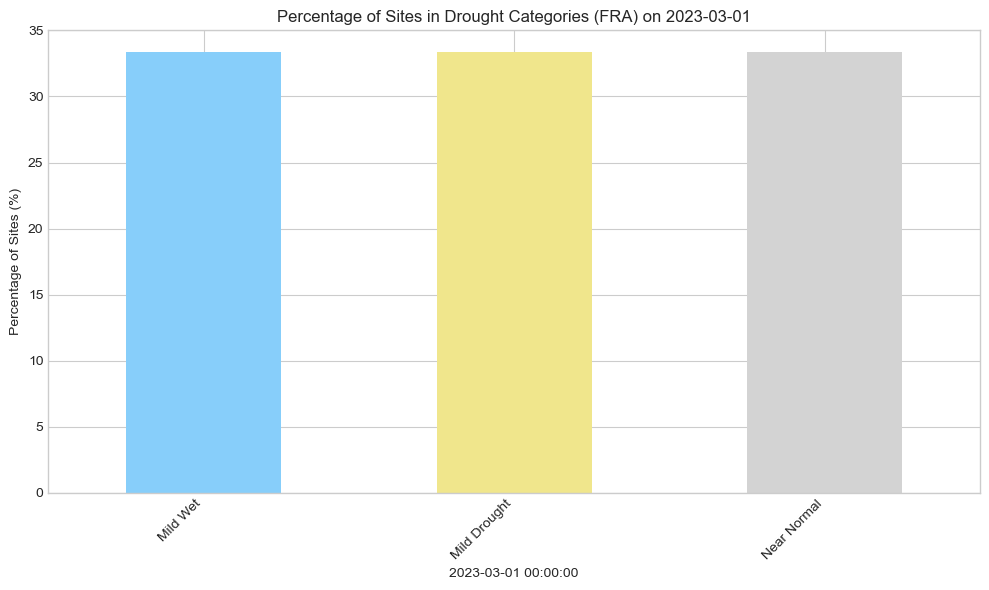

In [24]:
# Cell Type: code
# --- 10.1 Drought Classification Function & Application ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume TARGET_COUNTRY_SGI is defined elsewhere, e.g.:
TARGET_COUNTRY_SGI = "FRA"
# Assume sgi_results_selected_region_dict is populated, e.g., for demonstration:
# sgi_results_selected_region_dict = {
#     'site1': pd.Series([0.5, 1.0, -0.5, 2.5, np.nan], index=pd.to_datetime(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01'])),
#     'site2': pd.Series([1.5, -1.0, -2.5, 0.0, 0.8], index=pd.to_datetime(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01']))
# }
# This is just for the script to be runnable. Use your actual data.
# For testing, ensure sgi_results_selected_region_dict is not empty.
# Example:
dates = pd.to_datetime(
    [
        "2023-01-01",
        "2023-02-01",
        "2023-03-01",
        "2023-04-01",
        "2023-05-01",
    ]
)
sgi_results_selected_region_dict = {
    "SiteA": pd.Series(
        [1.2, 0.5, -0.8, 2.2, np.nan], index=dates, name="SiteA_SGI"
    ),
    "SiteB": pd.Series(
        [-1.5, 0.0, 0.9, 1.6, -2.1], index=dates, name="SiteB_SGI"
    ),
    "SiteC": pd.Series(
        [0.3, 1.3, -0.2, -1.2, 0.7], index=dates, name="SiteC_SGI"
    ),
}


print(f"\n--- Drought Classification and Analysis for {TARGET_COUNTRY_SGI} ---")

# SGI Drought Categories (Positive SGI = Drier/Deeper)
# Matching interpretation: Positive SGI from depth data means drought.
SGI_DROUGHT_CATEGORIES = {
    "Extreme Wet": (-np.inf, -2.0),
    "Severe Wet": (-1.9999, -1.5),
    "Moderate Wet": (-1.4999, -1.0),
    "Mild Wet": (-0.9999, -0.5),  # Adjusted slightly
    "Near Normal": (-0.4999, 0.4999),
    "Mild Drought": (0.5, 0.9999),
    "Moderate Drought": (1.0, 1.4999),
    "Severe Drought": (1.5, 1.9999),
    "Extreme Drought": (2.0, np.inf),
}

# --- SOLUTION: Define a color map for SGI categories ---
SGI_CATEGORY_COLORS = {
    "Extreme Wet": "navy",
    "Severe Wet": "blue",
    "Moderate Wet": "deepskyblue",
    "Mild Wet": "lightskyblue",
    "Near Normal": "lightgray",
    "Mild Drought": "khaki",
    "Moderate Drought": "orange",
    "Severe Drought": "red",
    "Extreme Drought": "darkred",
    "No Data": "#808080",  # Default grey for no data
}


def classify_sgi_drought_positive_is_dry(sgi_value):
    if pd.isna(sgi_value):
        return "No Data"
    # Check drought categories first (positive SGI)
    if sgi_value >= 2.0:
        return "Extreme Drought"
    if sgi_value >= 1.5:
        return "Severe Drought"
    if sgi_value >= 1.0:
        return "Moderate Drought"
    if sgi_value >= 0.5:
        return "Mild Drought"
    # Check wet categories (negative SGI)
    if sgi_value <= -2.0:
        return "Extreme Wet"
    if sgi_value <= -1.5:
        return "Severe Wet"
    if sgi_value <= -1.0:
        return "Moderate Wet"
    if sgi_value <= -0.5:
        return "Mild Wet"
    return "Near Normal"


if sgi_results_selected_region_dict:
    example_sgi_id_classify = list(sgi_results_selected_region_dict.keys())[
        0
    ]
    example_sgi_series_classify = sgi_results_selected_region_dict[
        example_sgi_id_classify
    ]

    drought_classification_region = example_sgi_series_classify.apply(
        classify_sgi_drought_positive_is_dry
    )
    print(
        f"\nDrought classification for site {example_sgi_id_classify} ({TARGET_COUNTRY_SGI}) (Head):"
    )
    # Assuming display is available (e.g., in Jupyter)
    # If not, use print(drought_classification_region.head())
    from IPython.display import display 
    display(drought_classification_region.head())

    print("\nValue counts of drought classes for this site:")
    display(drought_classification_region.value_counts())

    # --- Aggregate Analysis: Percentage of sites in drought ---
    all_sgi_df_region = pd.DataFrame(sgi_results_selected_region_dict)

    if not all_sgi_df_region.empty:
        common_dates = all_sgi_df_region.dropna(axis=0, how="all").index
        if not common_dates.empty:
            snapshot_date = common_dates[len(common_dates) // 2]

            sgi_on_snapshot_date = all_sgi_df_region.loc[
                snapshot_date
            ].dropna()

            if not sgi_on_snapshot_date.empty:
                print(
                    f"\nAnalyzing drought status for {TARGET_COUNTRY_SGI} on {snapshot_date.strftime('%Y-%m-%d')}"
                )
                classifications_snapshot = sgi_on_snapshot_date.apply(
                    classify_sgi_drought_positive_is_dry
                )
                status_counts_snapshot = (
                    classifications_snapshot.value_counts(normalize=True) * 100
                )

                plt.figure(figsize=(10, 6))

                # --- CORRECTED LINE ---
                # Use the SGI_CATEGORY_COLORS map to get colors
                # Provide a default color (e.g., 'grey') if a category is unexpectedly missing from the map
                plot_colors = [
                    SGI_CATEGORY_COLORS.get(cat, "grey")
                    for cat in status_counts_snapshot.index
                ]
                status_counts_snapshot.plot(kind="bar", color=plot_colors)
                # --- END OF CORRECTION ---

                plt.title(
                    f"Percentage of Sites in Drought Categories ({TARGET_COUNTRY_SGI}) on {snapshot_date.strftime('%Y-%m-%d')}"
                )
                plt.ylabel("Percentage of Sites (%)")
                plt.xticks(rotation=45, ha="right")
                plt.tight_layout()
                plt.show()
            else:
                print(
                    f"No SGI data available for the selected snapshot date: {snapshot_date}"
                )
        else:
            print("Could not determine a suitable snapshot date.")
    else:
        print("No SGI data to aggregate for regional analysis.")
else:
    print(f"No SGI results to classify for {TARGET_COUNTRY_SGI}.")

In [22]:
# Cell Type: code
# --- 11.1 Save Filtered Attributes, Monthly Data, and SGI Results ---
print(f"\n--- Saving Processed Data and SGI Results for {TARGET_COUNTRY_SGI} ---")

# 1. Save attributes of SGI-suitable sites in the target country
if not target_country_attributes_df.empty:
    try:
        filename = f"{TARGET_COUNTRY_SGI.lower()}_sgi_suitable_attributes.parquet"
        target_country_attributes_df.to_parquet(os.path.join(OUTPUT_PATH, filename), index=False)
        print(f"Successfully saved attributes to: {os.path.join(OUTPUT_PATH, filename)}")
    except Exception as e:
        print(f"Error saving attributes: {e}")
else:
    print(f"No suitable attributes for {TARGET_COUNTRY_SGI} to save.")

# 2. Save processed monthly groundwater depth data for the target country
if all_monthly_data_selected_region_dict:
    monthly_depth_list_region = []
    for grow_id, series in all_monthly_data_selected_region_dict.items():
        df_temp = series.reset_index()
        df_temp.columns = ["date", GW_VALUE_COL]
        df_temp["GROW_ID"] = grow_id
        monthly_depth_list_region.append(df_temp)
    
    if monthly_depth_list_region:
        target_country_monthly_depth_df = pd.concat(monthly_depth_list_region, ignore_index=True)
        target_country_monthly_depth_df = target_country_monthly_depth_df[["GROW_ID", "date", GW_VALUE_COL]]
        
        try:
            filename = f"{TARGET_COUNTRY_SGI.lower()}_monthly_gw_depth.parquet"
            target_country_monthly_depth_df.to_parquet(os.path.join(OUTPUT_PATH, filename), index=False)
            print(f"Successfully saved monthly depth data to: {os.path.join(OUTPUT_PATH, filename)}")
            print(f"  Shape: {target_country_monthly_depth_df.shape}")
        except Exception as e:
            print(f"Error saving monthly depth data: {e}")
else:
    print(f"No processed monthly depth data for {TARGET_COUNTRY_SGI} to save.")

# 3. Save calculated SGI results for the target country
if sgi_results_selected_region_dict:
    sgi_list_region = []
    for grow_id, series in sgi_results_selected_region_dict.items():
        df_temp = series.reset_index()
        df_temp.columns = ["date", "SGI"]
        df_temp["GROW_ID"] = grow_id
        sgi_list_region.append(df_temp)
        
    if sgi_list_region:
        target_country_sgi_results_df = pd.concat(sgi_list_region, ignore_index=True)
        target_country_sgi_results_df = target_country_sgi_results_df[["GROW_ID", "date", "SGI"]]

        try:
            filename = f"{TARGET_COUNTRY_SGI.lower()}_sgi_results.parquet"
            target_country_sgi_results_df.to_parquet(os.path.join(OUTPUT_PATH, filename), index=False)
            print(f"Successfully saved SGI results to: {os.path.join(OUTPUT_PATH, filename)}")
            print(f"  Shape: {target_country_sgi_results_df.shape}")
        except Exception as e:
            print(f"Error saving SGI results: {e}")
else:
    print(f"No SGI results for {TARGET_COUNTRY_SGI} to save.")


--- Saving Processed Data and SGI Results for FRA ---
Successfully saved attributes to: ./Daten/Processed/fra_sgi_suitable_attributes.parquet
Successfully saved monthly depth data to: ./Daten/Processed/fra_monthly_gw_depth.parquet
  Shape: (335715, 3)
Successfully saved SGI results to: ./Daten/Processed/fra_sgi_results.parquet
  Shape: (6040, 3)


In [ ]:
# Cell Type: code
# --- 12.1 Interactive SGI Map for Selected Country ---
if not GEOPANDAS_AVAILABLE:
    print("Skipping spatial visualization as GeoPandas or ipywidgets is not available.")
else:
    print(f"\n--- Visualization: Interactive SGI Map for {TARGET_COUNTRY_SGI} ---")

    if not target_country_sgi_results_df.empty and not target_country_attributes_df.empty:
        # Merge SGI data with attributes to get coordinates
        merged_sgi_attrs_target_df = pd.merge(
            target_country_sgi_results_df,
            target_country_attributes_df[['GROW_ID', 'latitude', 'longitude']],
            on="GROW_ID", how="left"
        )
        
        plot_gdf_target_full = merged_sgi_attrs_target_df.dropna(subset=['SGI', 'latitude', 'longitude'])
        if not plot_gdf_target_full.empty:
            plot_gdf_target_full = gpd.GeoDataFrame(
                plot_gdf_target_full,
                geometry=gpd.points_from_xy(plot_gdf_target_full.longitude, plot_gdf_target_full.latitude),
                crs="EPSG:4326"
            )

            unique_dates_target = sorted(plot_gdf_target_full['date'].unique())
            
            if unique_dates_target:
                output_plot_target = widgets.Output()

                # Define SGI categories and colors for the map legend
                sgi_map_legend_info = {
                    "Extreme Drought": '#8c0000', "Severe Drought": '#d73027',
                    "Moderate Drought": '#fc8d59', "Mild Drought": '#fee090',
                    "Near Normal": '#ffffbf',
                    "Mild Wet": '#e0f3f8', "Moderate Wet": '#91bfdb',
                    "Severe Wet": '#4575b4', "Extreme Wet": '#2c4a78',
                    "No Data": 'lightgrey'
                }

                def plot_sgi_map_target(date_idx_target):
                    with output_plot_target:
                        clear_output(wait=True)
                        selected_date_target = unique_dates_target[date_idx_target]
                        data_for_date_target = plot_gdf_target_full[plot_gdf_target_full['date'] == selected_date_target]
                        
                        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
                        
                        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
                        country_boundary_map = world[world.name == TARGET_COUNTRY_SGI.capitalize()] # Assuming country name matches
                        if TARGET_COUNTRY_SGI == "FRA": country_boundary_map = world[world.name == "France"]
                        if TARGET_COUNTRY_SGI == "USA": country_boundary_map = world[world.name == "United States of America"]


                        if not country_boundary_map.empty:
                            country_boundary_map.plot(ax=ax, edgecolor='black', color='whitesmoke', linewidth=0.7, zorder=1)
                        
                        if not data_for_date_target.empty:
                            data_for_date_target['color'] = data_for_date_target['SGI'].apply(lambda x: get_sgi_category_and_color(x)[1])
                            data_for_date_target.plot(
                                ax=ax, color=data_for_date_target['color'], markersize=40,
                                edgecolor='black', linewidth=0.5, alpha=0.8, zorder=2
                            )
                            
                            legend_elements_target = [plt.Line2D([0], [0], marker='o', color='w', label=cat,
                                                      markerfacecolor=col, markersize=10) for cat, col in sgi_map_legend_info.items()]
                            ax.legend(handles=legend_elements_target, title="SGI Categories", loc='lower left', fontsize='small')
                        else:
                            ax.text(0.5, 0.5, "No SGI data for this date", ha='center', va='center', transform=ax.transAxes)

                        ax.set_title(f"SGI in {TARGET_COUNTRY_SGI} on {pd.to_datetime(selected_date_target).strftime('%Y-%m-%d')}")
                        ax.set_xlabel("Longitude")
                        ax.set_ylabel("Latitude")
                        if not country_boundary_map.empty:
                            minx, miny, maxx, maxy = country_boundary_map.total_bounds
                            ax.set_xlim(minx - 0.5, maxx + 0.5)
                            ax.set_ylim(miny - 0.5, maxy + 0.5)
                        plt.grid(True, linestyle='--', alpha=0.7)
                        plt.show()

                date_slider_target = widgets.IntSlider(
                    value=0, min=0, max=len(unique_dates_target) - 1, step=1, description='Date:',
                    continuous_update=False, layout=widgets.Layout(width='80%')
                )
                date_label_target = widgets.Label()
                def update_date_label_target(change):
                    selected_dt_target = pd.to_datetime(unique_dates_target[change.new])
                    date_label_target.value = selected_dt_target.strftime('%Y-%m-%d')
                date_slider_target.observe(update_date_label_target, names='value')
                update_date_label_target({'new': date_slider_target.value})

                interactive_plot_target = interactive(plot_sgi_map_target, date_idx_target=date_slider_target)
                controls_target = HBox([date_slider_target, date_label_target])
                display(VBox([controls_target, output_plot_target]))
                plot_sgi_map_target(date_slider_target.value) # Initial plot
            else:
                print(f"No unique dates found in SGI data for {TARGET_COUNTRY_SGI} for interactive map.")
        else:
            print(f"Not enough data after merging/filtering for {TARGET_COUNTRY_SGI} for interactive map.")
    else:
        print(f"SGI or Attributes data for {TARGET_COUNTRY_SGI} not available for interactive map.")